Some weights of XLNetForQuestionAnsweringSimple were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions']
Epoch 1 - Train Loss: 3.071912662267685, Train Accuracy: 16.6%
Valid Loss: 1.7100666093826293, Valid Accuracy: 37.0%
Epoch 2 - Train Loss: 1.1681335092186929, Train Accuracy: 55.45%
Valid Loss: 1.5028907644748688, Valid Accuracy: 43.0%
Epoch 3 - Train Loss: 0.5084720551818609, Train Accuracy: 76.55%
Valid Loss: 1.711592983007431, Valid Accuracy: 45.5%
Epoch 4 - Train Loss: 0.3464797336012125, Train Accuracy: 85.15%
Valid Loss: 1.711592983007431, Valid Accuracy: 45.5%
Epoch 5 - Train Loss: 0.34647973111271857, Train Accuracy: 85.15%
Valid Loss: 1.711592983007431, Valid Accuracy: 45.5%
Epoch 6 - Train Loss: 0.34647973483800887, Train Accuracy: 85.15%
Valid Loss: 1.711592983007431, Valid Accuracy: 45.5%
Epoch 7 - Train Loss: 0.3464797332957387, Train Accuracy: 85.15%
Valid Loss: 1.711592983007431, Valid Accuracy: 45.5%
Epoch 8 - Train Loss: 0.34647973015904426, Train Accuracy: 85.15%
Valid Loss: 1.711592

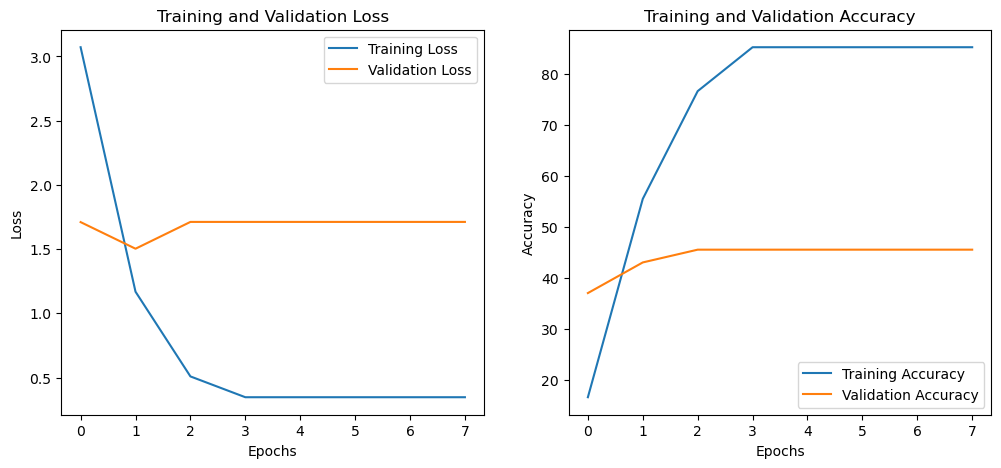

In [3]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import XLNetTokenizerFast, XLNetForQuestionAnsweringSimple, AdamW, get_linear_schedule_with_warmup
from datasets import load_dataset
import matplotlib.pyplot as plt
import time

# SQuAD dataset
squad_dataset = load_dataset('squad')

tokenizer = XLNetTokenizerFast.from_pretrained('xlnet-base-cased')
model = XLNetForQuestionAnsweringSimple.from_pretrained('xlnet-base-cased')

# Tokenization function with sliding window approach
def encode_examples(examples):
    inputs = tokenizer(
        examples['question'],
        examples['context'],
        truncation='only_second',
        padding='max_length',
        max_length=384,
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        return_tensors='pt'
    )
    
    offset_mapping = inputs.pop('offset_mapping')
    sample_mapping = inputs.pop('overflow_to_sample_mapping')
    
    start_positions = []
    end_positions = []

    for i, offsets in enumerate(offset_mapping):
        input_ids = inputs['input_ids'][i]
        sample_index = sample_mapping[i]
        answers = examples['answers'][sample_index]
        if len(answers['answer_start']) == 0:
            start_positions.append(0)
            end_positions.append(0)
        else:
            start_char = answers['answer_start'][0]
            end_char = start_char + len(answers['text'][0])
            sequence_ids = inputs.sequence_ids(i)

            context_start = sequence_ids.index(1)
            context_end = len(sequence_ids) - 1 - sequence_ids[::-1].index(1)

            token_start_index = context_start
            while token_start_index <= context_end and offsets[token_start_index][0] <= start_char:
                token_start_index += 1
            start_positions.append(token_start_index - 1)

            token_end_index = context_end
            while token_end_index >= context_start and offsets[token_end_index][1] >= end_char:
                token_end_index -= 1
            end_positions.append(token_end_index + 1)

    inputs['start_positions'] = torch.tensor(start_positions)
    inputs['end_positions'] = torch.tensor(end_positions)
    
    return inputs

# Apply the tokenization function to dataset
encoded_dataset = squad_dataset.map(encode_examples, batched=True, remove_columns=squad_dataset['train'].column_names)

print(encoded_dataset['train'].column_names)

class SquadDataset(Dataset):
    def __init__(self, encoded_dataset):
        self.dataset = encoded_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return {key: torch.tensor(self.dataset[key][idx]) for key in self.dataset.column_names}

sampled_size = 2000
train_val_split = encoded_dataset['train'].train_test_split(test_size=0.1)
sampled_train = train_val_split['train'].select(range(sampled_size))
sampled_val = train_val_split['test'].select(range(int(sampled_size * 0.1)))

train_dataset = SquadDataset(sampled_train)
val_dataset = SquadDataset(sampled_val)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Training
optimizer = AdamW(model.parameters(), lr=0.00002)
total_steps = len(train_loader) * 3 
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Mixed precision training scaler
scaler = torch.cuda.amp.GradScaler()

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

start_time = time.time()

epochs = 8
model.train()

for epoch in range(epochs):
    total_train_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    for batch in train_loader:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        with torch.cuda.amp.autocast():
            outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
            loss = outputs.loss
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_train_loss += loss.item()
        
        start_preds = torch.argmax(outputs.start_logits, dim=1)
        end_preds = torch.argmax(outputs.end_logits, dim=1)
        
        correct_predictions += ((start_preds == start_positions) & (end_preds == end_positions)).sum().item()
        total_predictions += input_ids.size(0)
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = (correct_predictions / total_predictions) * 100
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss}, Train Accuracy: {train_accuracy}%")
    
    # Evaluation
    model.eval()
    eval_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            with torch.cuda.amp.autocast():
                outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
                loss = outputs.loss
            
            eval_loss += loss.item()
            
            start_preds = torch.argmax(outputs.start_logits, dim=1)
            end_preds = torch.argmax(outputs.end_logits, dim=1)
            
            correct_predictions += ((start_preds == start_positions) & (end_preds == end_positions)).sum().item()
            total_predictions += input_ids.size(0)

    avg_eval_loss = eval_loss / len(val_loader)
    eval_accuracy = (correct_predictions / total_predictions) * 100
    val_losses.append(avg_eval_loss)
    val_accuracies.append(eval_accuracy)
    print(f"Valid Loss: {avg_eval_loss}, Valid Accuracy: {eval_accuracy}%")

end_time = time.time()

total_time = end_time - start_time
hours, remainder = divmod(total_time, 3600)
minutes, seconds = divmod(remainder, 60)
print(f"Total training time: {int(hours)}h {int(minutes)}m {int(seconds)}s")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

In [13]:
def answer_question(question, context):
    model.eval()
    inputs = tokenizer(question, context, return_tensors='pt', max_length=384, truncation=True, padding='max_length').to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    
    answer_start = torch.argmax(outputs.start_logits)
    answer_end = torch.argmax(outputs.end_logits)
    
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end+1]))
    return answer

question = "Who is the shooter?"
context = "Former President Donald Trump was shot and injured in an assassination attempt on Saturday night that also killed a spectator and critically injured two others. Snipers killed the shooter, a 20-year-old man, after he fired eight rounds at the rally in Butler, Pennsylvania. The former president could be seen touching his ear as the shooting unfolded before he was shielded by Secret Service and whisked offstage — with blood on his face — and into an SUV to safety. Trump said in a social media post that a bullet pierced the upper part of his right ear."
print(f"Question: {question}")
print(f"Answer: {answer_question(question, context)}")

Question: Who is the shooter?
Answer: 20-year-old man


In [14]:
question = "Who got attacked here?"
print(f"Question: {question}")
print(f"Answer: {answer_question(question, context)}")

Question: Who got attacked here?
Answer: Donald Trump


In [15]:
question = "Who killed the shooter?"
print(f"Question: {question}")
print(f"Answer: {answer_question(question, context)}")

Question: Who killed the shooter?
Answer: Snipers


In [16]:
question = "When this incident happened?"
print(f"Question: {question}")
print(f"Answer: {answer_question(question, context)}")

Question: When this incident happened?
Answer: Saturday night


In [18]:
question = "What happened to Donald Trump?"
print(f"Question: {question}")
print(f"Answer: {answer_question(question, context)}")

Question: What happened to Donald Trump?
Answer: an assassination attempt


In [19]:
question = "What Donald Trump shared in social media?"
print(f"Question: {question}")
print(f"Answer: {answer_question(question, context)}")

Question: What Donald Trump shared in social media?
Answer: said in a social media post that a bullet pierced the upper part of his right ear


In [8]:
model.eval()
correct_predictions = 0
total_predictions = 0

def compute_f1(preds, labels):
    common = set(preds) & set(labels)
    if len(common) == 0:
        return 0.0
    precision = len(common) / len(preds)
    recall = len(common) / len(labels)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

def compute_exact(preds, labels):
    return int(preds == labels)

total_f1 = 0.0
total_em = 0.0

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        with torch.cuda.amp.autocast():
            outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        
        start_preds = torch.argmax(outputs.start_logits, dim=1)
        end_preds = torch.argmax(outputs.end_logits, dim=1)

        for i in range(len(start_preds)):
            pred_span = input_ids[i][start_preds[i]:end_preds[i]+1]
            true_span = input_ids[i][start_positions[i]:end_positions[i]+1]

            pred_tokens = tokenizer.convert_ids_to_tokens(pred_span.cpu().numpy())
            true_tokens = tokenizer.convert_ids_to_tokens(true_span.cpu().numpy())

            pred_answer = tokenizer.convert_tokens_to_string(pred_tokens)
            true_answer = tokenizer.convert_tokens_to_string(true_tokens)

            total_f1 += compute_f1(pred_answer, true_answer)
            total_em += compute_exact(pred_answer, true_answer)

        correct_predictions += ((start_preds == start_positions) & (end_preds == end_positions)).sum().item()
        total_predictions += input_ids.size(0)

avg_f1 = total_f1 / total_predictions
avg_em = total_em / total_predictions

print(f"Evaluation - F1 Score: {avg_f1}, Exact Match: {avg_em}")

Evaluation - F1 Score: 0.5332851716804473, Exact Match: 0.465
